In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [0]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [0]:
data_lm.save()

In [0]:
data = load_data(path)

In [0]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

In [0]:
data.train_ds[0][0]

Text xxbos xxmaj please , someone stop xxmaj ben xxmaj stiller from acting in xxup any movie . xxmaj write the studios , hell , write your local congressman even . i 've gotten more laughs going to a funeral then i have watching xxup any xxmaj stiller flick . xxmaj jack xxmaj black tries to make something about a comedy about disappearing dog crap , and xxmaj christopher xxmaj walken , perhaps on of the greatest actors of his generation , simply looks embarrassed to be there . xxmaj stiller is his unfunny self , but now even with someone to xxunk him out , proves that he is way overrated as a comic . xxmaj it 's no wonder why this movie xxunk badly , and was available of the dollar movie theaters after only a handful of weeks . i warn you , and you must warn your friends , xxmaj do not watch this flick , it is just awful , worst then xxmaj xxunk ( personally , i 'd never thought i 'd say that ) , worst the xxmaj plan 9 , xxmaj worst the xxmaj ishtar , worst then xxmaj the xxmaj golden 

In [0]:
data.train_ds[0][0].data[:10]

array([   2,    4,  625,    9,  237,  790,    4,  584,    4, 3764])

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [0]:
bs=10

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

In [0]:

data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:

data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:

data_lm.show_batch()

idx,text
0,"of the story could have been good , with a better effort to depict the inner feelings of a man who had to live with alcohol and violence since his youth . \n \n xxmaj sadly , the general idea seems to be more like "" i 'm the way i am because that 's the way i am "" . xxmaj and the laughingly bad attempt at giving"
1,"xxmaj except that xxmaj jerry is n't as likeable as even poor dazed xxmaj tommy . xxmaj that 's another galling thing about this film . xxmaj jerry is sometimes a cad to xxmaj milo , and even worse to xxmaj lise . xxmaj when he first sees the latter at a club , he pulls a dirty trick to get her to dance with him . xxmaj when she"
2,"outgrown their parts ! xxmaj time does that to young stars . xxmaj yvonne xxmaj de xxmaj carlo , who re - xxunk her role as xxmaj lili , was pushing the xxmaj big 6 - 0 ( even though she still looked good and was still the perfect "" xxmaj lili "" ) . \n \n xxmaj it 's a shame that xxmaj yvonne xxmaj de xxmaj carlo"
3,"defend on his own . xxmaj if you 're a xxmaj foley fan , check this out . xxmaj no one takes a stiff butt kickin like xxmaj foley , and there are few examples of that as good as this . xxmaj nothing close to the spectacle of some of his other matches , this one is brutally short , emphasis on the ' brutal ' \n \n"
4,"mother . i was deeply moved . \n \n i now understand why my mother loved this film so much . xxbos xxmaj not xxup that boring , but not an xxmaj emmy winner either . xxmaj it 's basically the kind of film you 'd expect to see on xxmaj cinemax at about 1 xxup am . i 've never seen either of the main actresses in this"


In [0]:

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


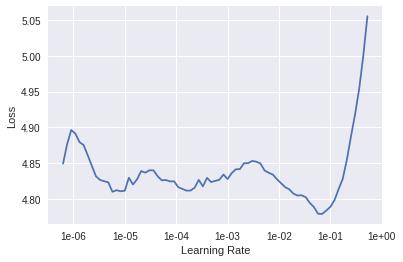

In [0]:

learn.recorder.plot(skip_end=15)

In [24]:

learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:

learn.unfreeze()

In [28]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


Buffered data was truncated after reaching the output size limit.

In [0]:

learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:

TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [34]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was so good . i have a problem with the movie , and i am My Fan . i do n't understand it , but i know Tom Cruise plays the guy who somehow gets
I liked this movie because it 's - bad acting , poor acting , bad directing , bad script , and bad acting . You really do n't take a movie seriously , and not the worst thing about it . The "


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
#classifier

path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [39]:

data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj there is no doubt that during the decade of the 30s , the names of xxmaj boris xxmaj karloff and xxmaj bela xxmaj lugosi became a sure guarantee of excellent performances in high quality horror films . xxmaj after being xxmaj universal 's "" first monster "" in the seminal classic , "" xxmaj dracula "" , xxmaj bela xxmaj lugosi became the quintessential horror villain thanks to",pos
"xxbos xxmaj my former xxmaj cambridge contemporary xxmaj simon xxmaj heffer , today a writer and journalist , has put forward the theory that , just as xxmaj british film - makers in the eighties were often critical of what they called "" xxmaj thatcher 's xxmaj britain "" , the xxmaj ealing comedies were intended as satires on "" xxmaj xxunk 's xxmaj britain "" , the xxmaj britain",pos
"xxbos [ xxup contains xxup spoilers ! ! ! ] \n \n xxmaj timon and xxmaj pumbaa are watching xxmaj the xxmaj lion xxmaj king . xxmaj timon decides to go back xxup before the beginning , to when the story really began . xxmaj so they go back . xxmaj way back . xxmaj back even before xxmaj simba was born . xxmaj back to xxmaj timon 's",neg
"xxbos xxmaj blood xxmaj castle ( aka xxmaj scream of the xxmaj demon xxmaj lover , xxmaj altar of xxmaj blood , xxmaj ivanna -- the best , but least exploitation cinema - sounding title , and so on ) is a very traditional xxmaj gothic xxmaj romance film . xxmaj that means that it has big , creepy castles , a headstrong young woman , a mysterious older man",pos


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [41]:

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


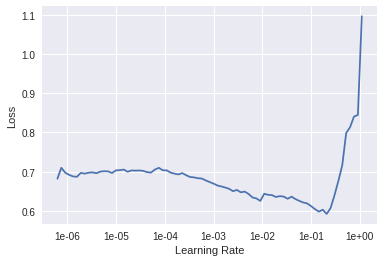

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.415282,0.312320,0.880640,40:04


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [46]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.372124,0.224140,0.912560,43:43


In [0]:

learn.save('second')

In [0]:

learn.load('second');

In [49]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.339120,0.358393,0.929480,56:46


In [0]:

learn.save('third')

In [0]:

learn.load('third');

In [53]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.277025,0.188285,0.932040,1:10:05
1,0.290140,0.182760,0.931200,1:10:20


In [54]:

learn.predict("I really loved that movie, it was awesome!")


(Category pos, tensor(1), tensor([3.4562e-04, 9.9965e-01]))